## Reinforcement Learning Environment

In [1263]:
import numpy as np
from typing import Dict, Tuple, List
import csv
from dataclasses import dataclass
from itertools import count
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque, namedtuple
import matplotlib
import matplotlib.pyplot as plt
import math
import random


In [1264]:
Transition = namedtuple("Transition", ("state", "action", "next_state", "reward"))

class Env: 
    _condition_symptom_probabilities: Dict[str, Dict[str, float]] # conditions with symptoms and their probabilities
    _actions: list[str] # symptoms
    _init_state: np.array
    _current_state: np.array
    _img: np.array
    _condition: str 
    _symptoms_of_condition: Dict[str, float] # symptoms of conditions
    _supported_conditions : list[str]
    
    def __init__(self,
                 img: np.array,
                 condition: str = None,
                ) -> None:  
        self._supported_conditions=["Alveolar Proteinosis", "Pertussis", "Lobar Pneumonia"]
        self._img = img
        if(condition is None): 
            condition = random.sample(self._supported_conditions,1)[0]
        self._condition = condition
            

        # init condition_symptom_probabilities from health knowledge graph
        #self._condition_symptom_probabilities= dict()
        #with open('HealthKnowledgeGraph.csv', newline='') as csvfile:
        #    reader = csv.reader(csvfile, delimiter=',')
        #    reader.__next__() # skip header
        #    for condition in reader:
        #        self._condition_symptom_probabilities[condition[0]] = dict()
        #        for symptom_prob in condition[1].split(','):
        #            # examples for symptom_prob: pain (0.318), fever (0.119) or swelling (0.112)
        #            symptom = symptom_prob.split('(')[0].strip()
        #            prob = float(symptom_prob.split('(')[1].split(')')[0])
        #            self._condition_symptom_probabilities[condition[0]][symptom] = prob

        # init condition_symptom_probabilities from slake knowledge graph 
        self._condition_symptom_probabilities= dict()
        with open('Slake1.0/KG/en_disease.csv', newline='') as csvfile:
            reader = csv.reader(csvfile, delimiter='#')
            reader.__next__() # skip header 
            for row in reader:
                if(row[1]!="symptom"):
                    continue
                if(row[0] not in self._supported_conditions):
                    continue
                self._condition_symptom_probabilities[row[0]] = dict()
                n_symptoms=len(row[2].split(','))
                uniform_prob = 1/(2**n_symptoms)
                for symptom in row[2].split(','):
                    #assign uniform conditional probability because no conditional probability are available 
                    self._condition_symptom_probabilities[row[0]][symptom.strip()] = uniform_prob

        # check if condition is valid
        if(self._condition not in self._condition_symptom_probabilities.keys()):
            raise ValueError('Unknow Condition: ' + condition + '. Please choose one of the following: ' + str(self._condition_symptom_probabilities.keys()))
        
        # init symptoms_of_condition for easier access
        self._symptoms_of_condition = dict()
        for symptom in self._condition_symptom_probabilities[self._condition]:
            self._symptoms_of_condition[symptom] = self._condition_symptom_probabilities[self._condition][symptom] 
    
        # init actions
        self._actions = list()
        for condition in self._condition_symptom_probabilities.keys(): 
            for symptom in list(self._condition_symptom_probabilities[condition]):
                if symptom not in self._actions:
                    self._actions.append(symptom) 

        # init init_state = vector with cnn output (probabilities per condition) and history of asked symptoms (0=not asked, 1=symptom is present, -1=symptom is not present)
        visual_prior = np.random.uniform(size=(len(self._condition_symptom_probabilities.keys()))) #TODO: replace with cnn output
        visual_prior = np.ones(shape=(len(self._condition_symptom_probabilities.keys())))
        self._init_state = np.concatenate((visual_prior,np.zeros((len(self._actions)))), axis=0)
        self._current_state = self._init_state

    def posterior_of_condition(self, condition: str) -> float: 
        #TODO: What is the correct likelihood calculation? If we use multiplication as in P(x,y)=P(x)*P(y), the likelihood gets smaller 
        #and nothing prevents the model from asking symptoms which are not related to the condition.
        likelihood=0 
        for idx, symptom in enumerate(self._actions):
            patient_answer = self._current_state[idx+len(self._condition_symptom_probabilities.keys())]
            #if (patient_answer==1) and (symptom not in self._condition_symptom_probabilities[condition].keys()):
            #    likelihood*= 0
            #elif (patient_answer==-1) and (symptom not in self._condition_symptom_probabilities[condition].keys()):
            #    likelihood*=1
            if (symptom not in self._condition_symptom_probabilities[condition].keys()):
                #TODO: Do we have to punish the model if a symptom is positive and is not related to the condition?
                continue 
            elif patient_answer==1:
                likelihood+=self._condition_symptom_probabilities[condition][symptom]
            elif patient_answer==-1:
                likelihood+=(1-self._condition_symptom_probabilities[condition][symptom]) 

        prior = self._current_state[list(self._condition_symptom_probabilities.keys()).index(condition)]
        return likelihood*prior
    
    def reward(self) -> float:
        #TODO: Is it a problem when the reward gets smaller and smaller?
        punishment=0
        for i in range(len(self._actions)):
            patient_answer = self._current_state[i+len(self._condition_symptom_probabilities.keys())]
            if (patient_answer!=0):
                punishment+=0.5
        return self.posterior_of_condition(self._condition)-punishment
    
    def has_symptom(self, symptom: str) -> bool:
        if symptom not in self._symptoms_of_condition:
            return False
        else:
            phi = np.random.uniform()
            return phi <= self._symptoms_of_condition[symptom]

    def step(self, action_idx: int) -> Transition: 
        action = self._actions[action_idx]
        old_state = self._current_state.copy()
        self._current_state[len(self._condition_symptom_probabilities.keys()) + action_idx] = 1 if self.has_symptom(action) else -1
        
        return Transition(old_state, action_idx, self._current_state, self.reward())
    
    def reset(self) -> np.array:
        self._current_state = self._init_state
        return self._current_state

In [1265]:
class ReplayMemory():
    def __init__(self, capacity):
        self.memory=deque([], maxlen=capacity)
    def push(self, transition):
        self.memory.append(transition)
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    def __len__(self):
        return len(self.memory)

In [1266]:
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128, dtype=torch.double)
        self.layer2 = nn.Linear(128, 128, dtype=torch.double)
        self.layer3 = nn.Linear(128, n_actions, dtype=torch.double)
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [1267]:
#is_ipython = "inline" in matplotlib.get_backend()
#if is_ipython:
#    from IPython import display
#plt.ion()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [1268]:
myEnv=Env(np.array([]), 'Pertussis')

In [1269]:
# BATCH_SIZE is the number of transitions sampled form the replay buffer
#GAMMA is the discount factor as mentioned in the previous section
#SIZE is the number of transitions sampled from the replay buffer
#EPS START is the starting value of epsilon
#EPS DECAY controls the rate of exposential decay of epsilon, higher means a slower decay
#EPS END is the final value of epsilon
#TAU is the update rate of the target network IN is the learning rate of the Adams optimizar
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 10000
TAU = 0.005
LR = 1e-5

#Get number of actions from gym action spane
myEnv.reset()
n_actions = len(myEnv._actions)
n_observations = len(myEnv._current_state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0 

In [1270]:
def optimize_model(losses, gradient_norms):
    if len(memory) < BATCH_SIZE: 
        return
    transitions = memory.sample(BATCH_SIZE)
    #converts batch_array of Transitions to Transition of batch_arrays
    batch = Transition(*zip(*transitions))

    next_state_batch = torch.tensor(batch.next_state)
    state_batch = torch.tensor(batch.state)
    action_batch = torch.tensor(batch.action)
    reward_batch = torch.tensor(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch[None,:])

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values = target_net(next_state_batch).max(1)[0]

    #TODO: state_action_values grow infinitely
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values.squeeze(), expected_state_action_values)

    losses.append(loss.detach())

    parameters = [p for p in policy_net.parameters() if p.grad is not None and p.requires_grad]
    if len(parameters) == 0:
        total_norm = 0.0
    else: 
        total_norm = torch.norm(torch.stack([torch.norm(p.grad.detach()).to(device) for p in parameters]), 2.0).item()
    gradient_norms.append(total_norm)
    
    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_value_(policy_net.parameters(),100)
    optimizer.step()

In [1271]:
def select_action(myEnv, state, epsilon, epsilons):
    randnum = np.random.rand(1)
    if randnum < epsilon:
        action_idx = np.random.randint(len(myEnv._actions))
    else:
        with torch.no_grad():
            action_idx = np.argmax(policy_net(torch.tensor(state))).item() 
    
    return action_idx

In [1272]:
num_episodes = 12000
len_episode = 10
i_decay=1
epsilon = EPS_START
losses=[]
gradient_norms=[]
rewards=[]
epsilons=[]
total_reward_per_episode=[]

for _ in range(num_episodes):
    myEnv=Env(np.array([]))
    state = myEnv.reset()
    for _ in range(len_episode):
        if epsilon > EPS_END:
            epsilon = EPS_START * math.exp(-i_decay/EPS_DECAY)
            i_decay+=1 
        epsilons.append(epsilon)
        action_idx = select_action(myEnv, state, epsilon, epsilons)
        transition = myEnv.step(action_idx)
        rewards.append(transition.reward)
        last_reward=transition.reward
        memory.push(transition)
        state = transition.next_state
        optimize_model(losses, gradient_norms)

        #Soft update of target  network weights
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)
    total_reward_per_episode.append(last_reward)

    #episode_durations.append(t + 1)
    #plot_durations()

print("complete")
#plot_durations(show_result=True)
#plt.ioff()
#plt.show() 

complete


In [1273]:
# helper function
def averagewindow(R, d=1):
    n = len(R)
    t = []
    y = []
    for i in range(0,int(n/d)):
        t.append(np.mean(range(i*d,(i+1)*d)))
        y.append(np.mean(R[i*d:min(n,(i+1)*d)]))
    return t,y

Text(0.5, 1.0, 'losses')

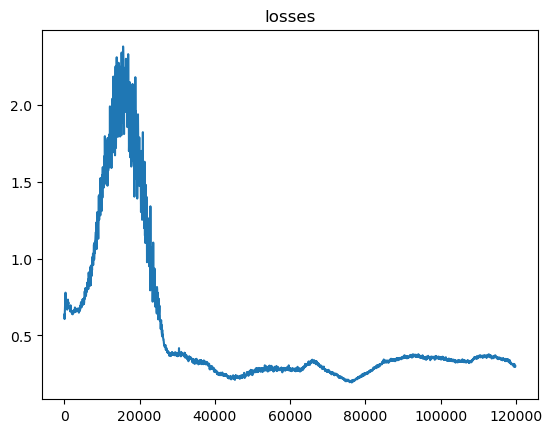

In [1274]:
t,y = averagewindow(losses, d=50)
plt.plot(t,y)
plt.title("losses")

Text(0.5, 1.0, 'gradient norms')

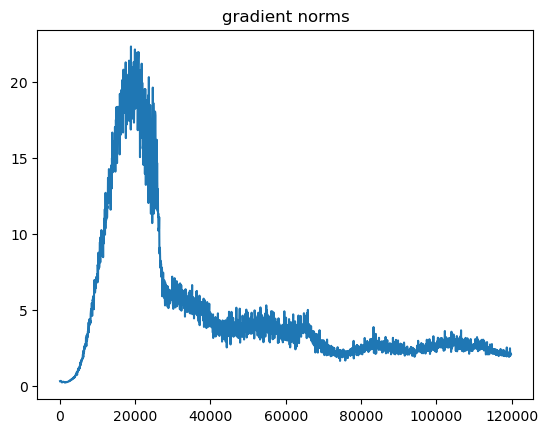

In [1275]:
t,y = averagewindow(gradient_norms, d=50)
plt.plot(t,y)
plt.title("gradient norms")

Text(0.5, 1.0, 'Rewards')

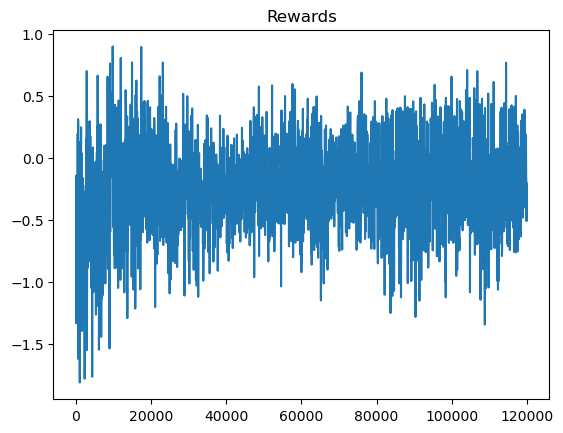

In [1276]:
t,y = averagewindow(rewards, d=50)
plt.plot(t,y)
plt.title("Rewards")

Text(0.5, 1.0, 'Total reward per episode')

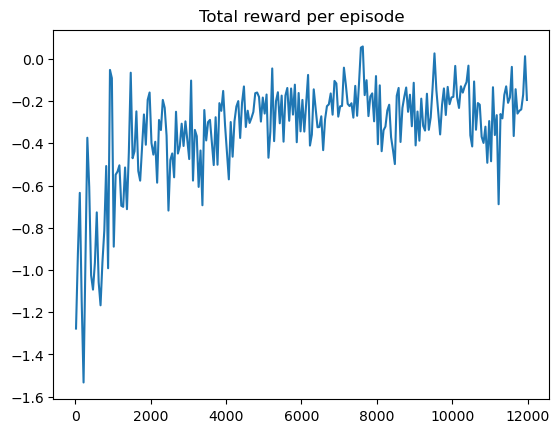

In [1277]:
t,y = averagewindow(total_reward_per_episode, d=50)
plt.plot(t,y)
plt.title("Total reward per episode")

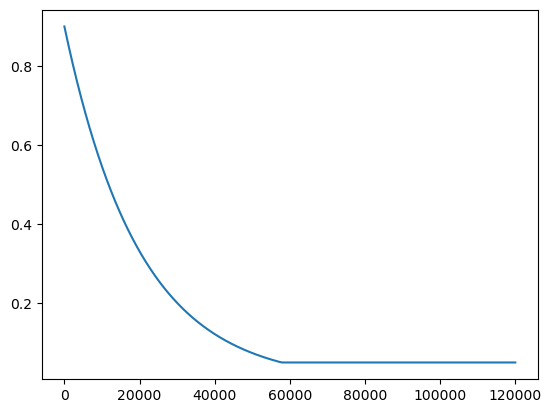

In [1278]:
plt.plot(epsilons)

### Test cases

In [1279]:
#Testing simulated patient answers
myTestEnv=Env(np.array([]), 'Pertussis')
print("Symptoms for Pertussis:")
print(myTestEnv._condition_symptom_probabilities['Pertussis'])
print("Expected uniform conditional proabability: 1\(", 2**len(myTestEnv._condition_symptom_probabilities['Pertussis'].keys()), ")")
n=0
prob=0
for i in range(10000):
    n+=1
    if myTestEnv.has_symptom('spastic cough'):
        prob+=1 
print("\n Probability of spastic cough after 10000 samples: " + str(prob/n))

Symptoms for Pertussis:
{'spastic cough': 0.5}
Expected uniform conditional proabability: 1\( 2 )

 Probability of spastic cough after 10000 samples: 0.4976


In [1280]:
#Testing reward
myTestEnv=Env(np.array([]), 'Alveolar Proteinosis')
print("prior of condition:")
print(myTestEnv._current_state[list(myTestEnv._condition_symptom_probabilities.keys()).index("Alveolar Proteinosis")])

myTestEnv.step(myTestEnv._actions.index('cyanosis'))
result=myTestEnv._current_state[len(myTestEnv._condition_symptom_probabilities.keys()) + list(myTestEnv._actions).index('cyanosis')] 
print("Probability of cyanosis: " + str(myTestEnv._condition_symptom_probabilities['Alveolar Proteinosis']['cyanosis']))
print("Result patient asking if he has cyanosis: " + str(result))

myTestEnv.step(myTestEnv._actions.index('chest pain'))
result=myTestEnv._current_state[len(myTestEnv._condition_symptom_probabilities.keys()) + list(myTestEnv._actions).index('chest pain')] 
print("Probability of chest pain: " + str(myTestEnv._condition_symptom_probabilities['Alveolar Proteinosis']['chest pain']))
print("Result patient asking if he has chest pain: " + str(result))

myTestEnv.step(myTestEnv._actions.index('dyspnea'))
result=myTestEnv._current_state[len(myTestEnv._condition_symptom_probabilities.keys()) + list(myTestEnv._actions).index('dyspnea')] 
print("Probability of dyspnea: " + str(myTestEnv._condition_symptom_probabilities['Alveolar Proteinosis']['dyspnea']))
print("Result patient asking if he has dyspnea: " + str(result))

print("Reward: " + str(myTestEnv.reward()))

prior of condition:
1.0
Probability of cyanosis: 0.0625
Result patient asking if he has cyanosis: -1.0
Probability of chest pain: 0.0625
Result patient asking if he has chest pain: -1.0
Probability of dyspnea: 0.0625
Result patient asking if he has dyspnea: -1.0
Reward: 1.3125
